## Historical Price Data EDA

In [1]:
import os
os.chdir(os.environ['PWD'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
import re
import string
import boto3

#### Import Historical Data

In [3]:
# Load ENV secrets
# assert load_dotenv(), "Environment file couldnt load"
AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_KEY")
AWS_BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

# Create an S3 client
s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)

# Load the dataset from S3
objects = s3_client.list_objects_v2(Bucket=AWS_BUCKET_NAME, Prefix = sts.S3_PROJECT_PATH)
pqt_objects = [obj for obj in objects['Contents'] if obj['Key'].endswith('.parquet')]
last_pqt_object = sorted(pqt_objects, key=lambda x: x['LastModified'], reverse=True)[0]

s3_client.download_file(Filename = 'data.parquet', Bucket=AWS_BUCKET_NAME, Key=last_pqt_object['Key'])

In [12]:
dataset = pd.read_parquet('data.parquet')

In [13]:
dataset.shape

(298069, 4)

In [14]:
dataset.head()

,date,product,market,mean_price
0,2013-01-01,alas de pollo con costillar,barranquilla barranquillita,3073.0
1,2013-02-01,alas de pollo con costillar,barranquilla barranquillita,3063.0
2,2013-03-01,alas de pollo con costillar,barranquilla barranquillita,2913.0
3,2013-04-01,alas de pollo con costillar,barranquilla barranquillita,2894.0
4,2013-05-01,alas de pollo con costillar,barranquilla barranquillita,3040.0


In [15]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [16]:
dataset['date'].describe()

count                           298069
mean     2018-04-01 11:20:18.897638144
min                2013-01-01 00:00:00
25%                2015-08-01 00:00:00
50%                2018-04-01 00:00:00
75%                2020-12-01 00:00:00
max                2023-07-01 00:00:00
Name: date, dtype: object

#### Class Descriptions

In [18]:
dataset['product'].value_counts().head(20)

product
pimenton                   4445
tomate de arbol            4064
cilantro                   3810
habichuela                 3810
platano harton verde       3556
sal yodada                 3556
mora de castilla           3429
papa criolla limpia        3429
lechuga batavia            3429
pepino cohombro            3302
lenteja importada          3302
arroz de primera           3175
apio                       3048
cebolla cabezona blanca    3048
lulo                       2921
guayaba pera               2921
banano criollo             2921
repollo blanco             2794
chocolo mazorca            2794
maracuya                   2667
Name: count, dtype: int64

In [19]:
dataset['product'].nunique()

279

In [20]:
dataset['market'].value_counts()

market
medellin central mayorista de antioquia        18669
bogota dc corabastos                           12700
villavicencio cav                              11557
ibague plaza la 21                             11303
bucaramanga centroabastos                      10668
manizales centro galerias                      10160
barranquilla barranquillita                    10160
monteria mercado del sur                        9652
palmira valle del cauca                         9652
medellin plaza minorista jose maria villa       9398
cucuta cenabastos                               9271
tulua valle del cauca                           9017
popayan plaza de mercado del barrio bolivar     9017
armenia mercar                                  8890
sincelejo nuevo mercado                         8255
neiva surabastos                                8255
pereira mercasa                                 8128
cartagena bazurto                               8001
cartago valle del cauca                

## Time Series Analysis

In [21]:
date_range = pd.date_range(start = dataset['date'].min(), end = dataset['date'].max(), freq = 'MS')

In [22]:
selected_markets = [
    'medellin central mayorista de antioquia', 
    'bogota dc corabastos',
    'cucuta cenabastos',
    'barranquilla barranquillita'
                   ]

In [23]:
selected_product = 'huevo rojo aa'

In [24]:
filter_key = (dataset['market'].isin(selected_markets)) & (dataset['product']==selected_product)

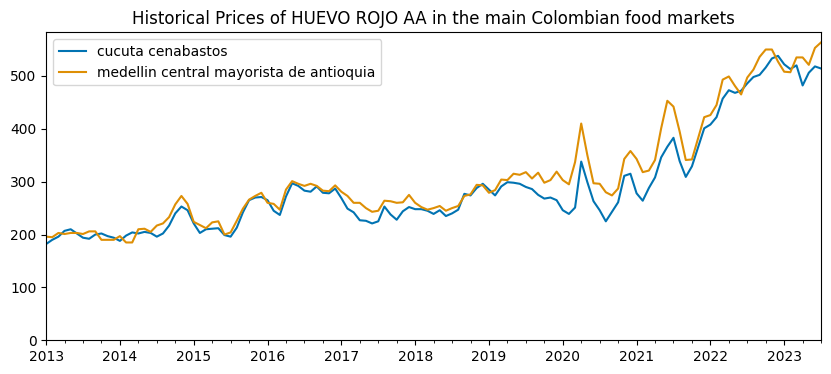

In [25]:
plt.figure(figsize=(10,4))
for key, df_key in dataset.loc[filter_key].groupby('market'):
    price_series = df_key.set_index(['date']).reindex(date_range)
    price_series['mean_price'].plot(label=key)
plt.ylim(bottom=0)
plt.title(f"Historical Prices of {selected_product.upper()} in the main Colombian food markets")
plt.legend()
plt.show()

### Dataset Completeness Analysis

In [26]:
dataset_pivot = dataset.pivot(index='date', columns = ['group', 'product', 'market'], values = 'mean_price')

In [27]:
dataset_pivot = dataset_pivot.reindex(date_range)

In [28]:
dataset_pivot.shape

(119, 6541)

In [29]:
val = dataset_pivot.dropna(axis = 1).shape[1] / dataset_pivot.shape[1]
print(f"{round(val*100, 2)}% of market-product time series have all {dataset_pivot.shape[0]} data points")

36.45% of market-product time series have all 119 data points


In [30]:
val = dataset_pivot[-36:].dropna(axis = 1).shape[1] / dataset_pivot.shape[1]
print(f"{round(val*100, 2)}% of market-product time series have all 36 data points in the last 3 years")

52.16% of market-product time series have all 36 data points in the last 3 years


In [31]:
val = dataset_pivot[-24:].dropna(axis = 1).shape[1] / dataset_pivot.shape[1]
print(f"{round(val*100, 2)}% of market-product time series have all 24 data points in the last 2 years")

54.12% of market-product time series have all 24 data points in the last 2 years


### Filter Dataset - Select Series to Forecast

In [43]:
# Select only time series with the last 3 years of complete history
dataset_pivot_filtered = dataset_pivot.loc[:, dataset_pivot[-36:].dropna(axis = 1).columns]

In [45]:
len(dataset_pivot[-36:].dropna(axis = 1).columns) / dataset_pivot.shape[1]

0.5216327778627121

In [33]:
dataset_pivot_filtered.shape

(119, 3412)

In [50]:
dataset_filtered = dataset_pivot_filtered.unstack().reset_index(['group', 'product', 'market'])

In [31]:
nunique_products = dataset_filtered['product'].nunique()
print(f"{round(nunique_products, 2)} unique products across markets")

319 unique products across markets


In [32]:
nunique_markets = dataset_filtered['market'].nunique()
print(f"{round(nunique_markets, 2)} unique markets")

72 unique markets


In [33]:
df_temp = dataset_filtered.loc['2022-11-01'].groupby(['market'])['product'].nunique().sort_values(ascending=False).reset_index()

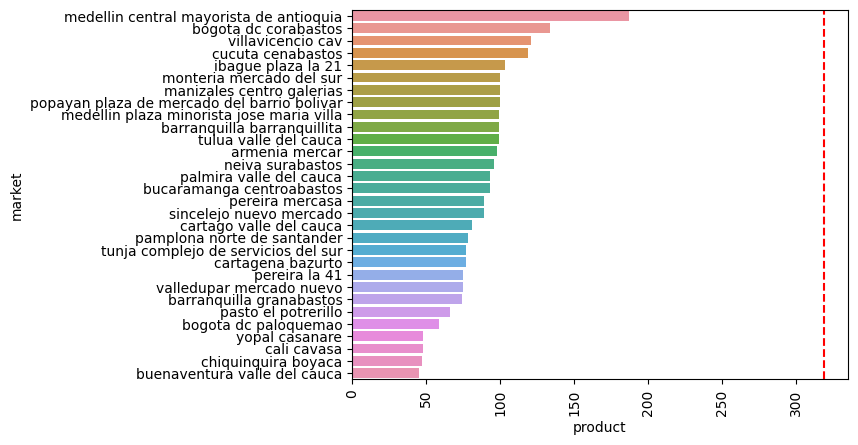

In [34]:
sns.barplot(y = 'market', x = 'product', data = df_temp.head(30))
plt.axvline(nunique_products, linestyle = '--', color ='r', label = 'all_products')
plt.xticks(rotation = 90)
plt.show()

In [35]:
df_temp = dataset_filtered.loc['2022-11-01'].groupby(['product'])['market'].nunique().sort_values(ascending=False).reset_index()

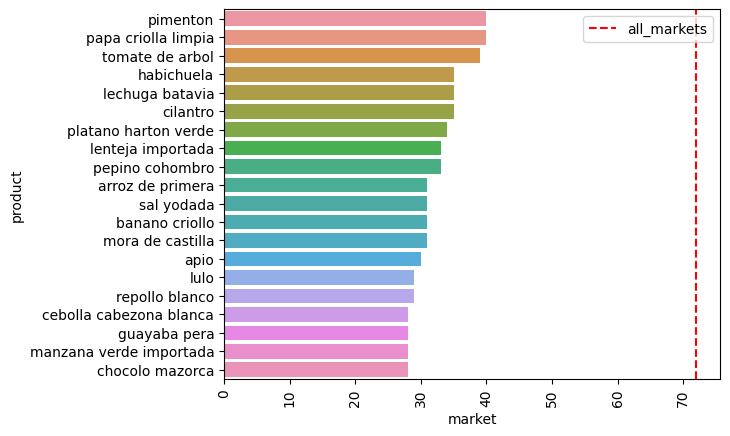

In [36]:
#plt.figure(figsize = (10,10))
sns.barplot(y = 'product', x = 'market', data = df_temp.head(20))
plt.xticks(rotation = 90)
plt.axvline(nunique_markets, linestyle = '--', color ='r', label = 'all_markets')
plt.legend()
plt.show()

In [37]:
dataset_filtered = dataset_filtered.reset_index()
dataset_filtered.columns = ['date', 'group', 'product', 'market', 'mean_price']

In [38]:
# Save Filtered Dataset
dataset_filtered.to_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_filtered.csv", index=False)